In [12]:
%%html
<style>
.output_png {
    display: table-cell;
    text-align: center;
    margin:auto;
}
.prompt 
    display:none;
}  
</style>

## Description of the problem

In many economics and buisness problems, a prerequisite of the analysis is to precisely describe the markets of the firms under study. This includes gathering demand-side information such as the characteristics of consumers in the market, and supply-side information characterizing a firm's competitors.

In many cases (e.g. retail stores, restaurants, etc.), the markets of firms are local in a geographical sense: consumers and competitors are physically located close to the firm. Computing demand-side and supply-side market characteristics then involves dealing in some ways with geographical datasets. This post presents some tools and methods that can be used when one runs into problems like this one. As an illustration, I will focus on determining the market characterics of all bakeries in France.

## Data

I will mainly be using two open-access datasets provided by [Insee](https://insee.fr/en/accueil), the French statistical office. The first one is the [Sirene dataset](https://www.data.gouv.fr/en/datasets/base-sirene-des-entreprises-et-de-leurs-etablissements-siren-siret/), which is a nearly exhaustive registry of French businesses, listing all active establishments of all firms in France at a given date. Establishments are uniquely identified by their [Siret number](https://en.wikipedia.org/wiki/SIRET_code), which can be used to gather additionnal information from other data sources (such as revenu, profit, etc. but this is beyond the scope of this post). The data also provides information on the establishment's industry (in the [NAF rev. 2 classification](https://www.insee.fr/fr/information/2120875)) as well as its address, which can be used to geocode the dataset (see e.g. [this post](https://medium.com/@cq94/g%C3%A9ocodage-de-la-base-sirene-2f0e14e87a8d) on how to do this). I will focus on bakeries, identified by industry code 1071C, and will use an already geocoded dataset to define bakeries' markets and to identify each bakery's competitors.

The [second dataset](https://insee.fr/fr/statistiques/4176281?sommaire=4176305#consulter) I will use provides information on family structure and household income at a very detailed geographical level (down to a 200m-by-200m grid). This gridded data is built from several exhaustive administrative data sources such as tax files. It will provide the basic information on a store's consumers' characteristics when it is intersected with bakeries' market boundaries.

In [19]:
import os
import pandas as pd
import geopandas as gpd

dir_path = os.path.abspath('')
data_path = os.path.join(dir_path, 'data')

# Geolocalized data on bakeries build from Sirene
sir_geo = pd.read_csv(os.path.join(data_path,'bakeries.csv'), dtype={'siret': object, 'depcom': str})
sir_geo = gpd.GeoDataFrame(sir_geo, geometry=gpd.points_from_xy(sir_geo.x, sir_geo.y))
#sir_geo = sir_geo.sample(1000)

# Gridded data
rect = gpd.read_file(os.path.join(data_path,'Filosofi2015_carreaux_niveau_naturel_metropole.shp'))

# French administrative boundaries (excluding Corsica) - will be used to delimit markets
fradm = gpd.read_file(os.path.join(data_path,'gadm36_FRA_1.shp'))
fradm = fradm.loc[(fradm['NAME_1']!='Corse'), 'geometry'].unary_union


## Construction of the markets

There are many ways to define the geographical market of a business, with little consensus on how to proceed as far as I know. A reasonable approach to this problem may be to consider that businesses will likely have a primary market, typically comprising all consumers who are closest to this business than to any other, and a secondary market which can overlap with one or several other businesses' primary markets. In this definition, the primary market of all bakeries in France can be constructed by building a Voronoi diagram from all store locations. For the secondary market, two definitions might be interesting to play around with (but surely there are others): (i) consumers within a certain distance of the store (either straight-line distance or driving distance), and (ii) consumers for whom a given store is the *n*th closest (this can be done using higher-order Voronoi diagrams, see e.g. [this link](http://www.cs.utah.edu/~justin/Wares/HOV_README.html)). 

I will ignore secondary markets for now and focus on primary markets. Voronoi diagrams can be easily computed and plotted in python using tools available in the `scipy.spatial` module.

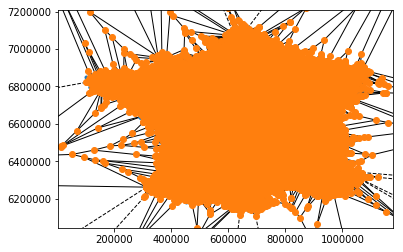

In [20]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
%matplotlib inline

_vor = Voronoi(sir_geo[['x', 'y']])
fig = voronoi_plot_2d(_vor)
plt.show()

In this plot, store locations are shown as blue dots, while the vertices of the Voronoi diagram are shown as orange dots and the ridges of the Voronoi regions are shown as black lines. Each Voronoi region defines the primary market of the store contained in this region.

This plot reveals a basic problem with our definition of markets: for stores at the edge of the diagram, the Voronoi region may be infinite. This corresponds to Voronoi regions with dashed ridges in the plot. Diving into the object returned by `scipy`, infinite regions can be spotted because their list of vertex indices holds a `-1` in some position, while all vertex indices are positive for "inside" (or closed) regions. We can draw individual Voronoi regions to inspect the problem more precisely.

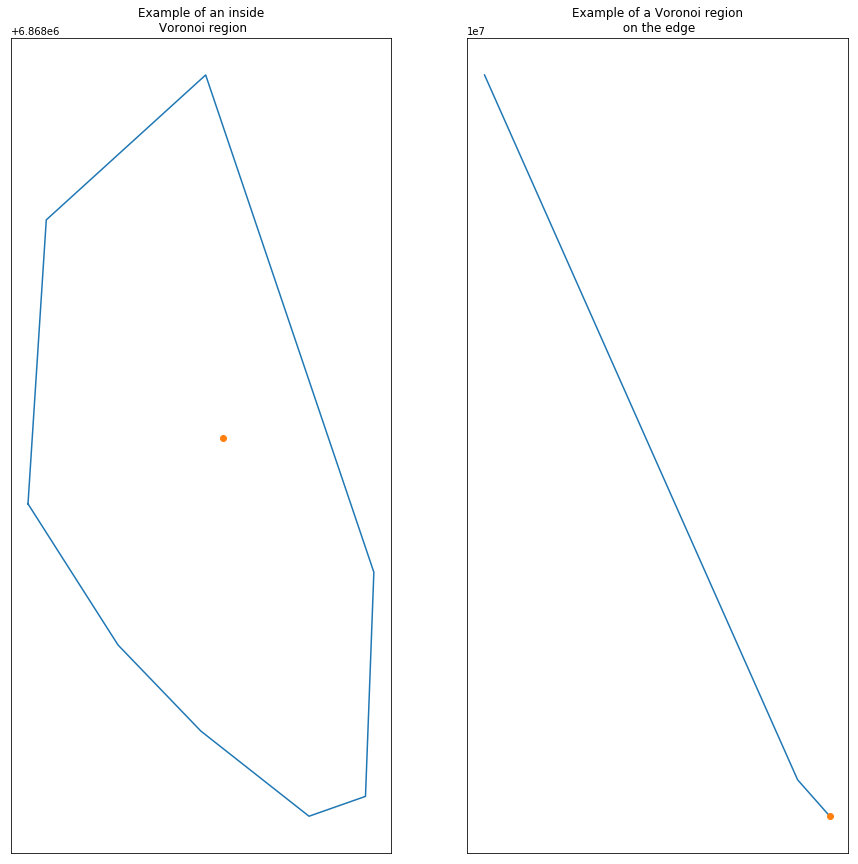

In [37]:
from shapely.geometry import LineString, MultiLineString, Polygon
from shapely.geometry.collection import GeometryCollection
from shapely import ops
import random as rd

def draw_voronoi_region(vor, point_index, ax=None):
    """Draw the voronoi cell associated to a given point"""
    
    region = vor.regions[vor.point_region[point_index]]
    point = vor.points[point_index]
    segments = [s for s in zip(region, region[1:]+region[:1])]
    lines = MultiLineString([_vor.vertices[[a, b]] for a, b in segments if a!=-1 and b!=-1])
    if not ax:
        fig, ax = plt.subplots(1,1)
    ax.plot(*ops.linemerge(lines).xy)
    ax.plot(*point, marker='o')
    

edge_pts_idx = [i for i in range(_vor.npoints) if -1 in _vor.regions[_vor.point_region[i]]]
inside_pts_idx = [i for i in range(_vor.npoints) if -1 not in _vor.regions[_vor.point_region[i]]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
draw_voronoi_region(_vor, rd.choice(inside_pts_idx), ax1)
ax1.set_title("Example of an inside\n Voronoi region")
draw_voronoi_region(_vor, rd.choice(edge_pts_idx), ax2)
ax2.set_title("Example of a Voronoi region\n on the edge")
for ax in [ax1, ax2]:
    ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
plt.show()

In order to build well-defined polygons describing the geographical market of all stores in the data, we need to close the Voronoi regions on the edge, e.g. by clipping to the country's borders. This involves constructing new vertices located on the country's border for edge regions. To make things (much) faster and easier, I consider first constructing these vertices on a bounding box of the country's border. In this setting, given a set of stores $(p_0, p_1)$ on the edge of the diagram, separated by a Voronoi ridge running from vertex $v_0$ to infinity, the geometrical intuition for the construction of the new vertex (or "far point") $v_1$ is as follows:
        ![Far point diagram](../geomarketing_files/far_point_construction.png)        
This construction uses two properties of Voronoi ridges: (i) they are orthogonal to the line connecting the two points they separate, and (ii) they run through the middle of this line. These properties are straightforward as, by definition, Voronoi ridges are equidistant from both points. In the implementation below, we use the `ridge_dict` attribute of the Voronoi object returned by `scipy`, which associates each ridge described as a pair of vertices $(v_0, v_1)$ in the Voronoi diagram with the input points $(p_0, p_1)$ that this ridge separates.

In [23]:
import numpy as np
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon, LineString, GeometryCollection

def far_point(pts, vertex, center, bounds):
    """Compute far point on the bounding box for a voronoi ridge at the edge. 
    
    Args:
        pts: the two points that this ridge separates
        vertex: the existing vertex for this ridge
        center: the central point of the Voronoi's input points
        bounds: bounding box on which to compute the far point for the ridge
    """
    
    xmin, ymin, xmax, ymax = bounds
    t = pts[1] - pts[0]  # tangent is orthogonal to the ridge
    t = t / np.linalg.norm(t)
    n = np.array([-t[1], t[0]]) # normal gives orientation of far point 
    midpoint = pts.mean(axis=0)
    n = np.sign(np.dot(midpoint - center, n)) * n # Might need to reverse direction
    # If the ridge is vertical
    if n[0]==0:
        xt = midpoint[0]
        yt = ymax if n[1] > 0 else ymin
    # If the ridge is not vertical
    else:
        slope = n[1] / n[0]
        intercept = midpoint[1] - slope * midpoint[0]
        xt = xmax if n[0] > 0 else xmin
        yt = intercept + slope * xt
        if yt < ymin:
            yt = ymin
            xt = (ymin - intercept) / slope
        elif yt > ymax:
            yt = ymax
            xt = (ymax - intercept) / slope
    return np.array([xt, yt])

def close_cell(far_points, l, center, bounds):
    """Close voronoi cells at the edge by clipping to bounding box.
    
    Args:
        far_points: the list of far vertices associated to the Voronoi
            cell for this point
        l: the list of existing segments for the Voronoi cell of this
        point
        center: the central point of the input points
        bounds: coordinates of the bounding box for the Voronoi diagram
    """
    
    xmin, ymin, xmax, ymax = bounds
    p1 = far_points[0]
    p2 = far_points[1]
    if p1[0]==xmin or p1[0]==xmax:
        if p2[0]==p1[0]:
            l.append(LineString([p1, p2]))
        elif p2[0]==xmin or p2[0]==xmax:
            y = ymin if center[1] > p1[1] else ymax
            a1 = np.array([p1[0], y])
            a2 = np.array([p2[0], y])
            l.extend([LineString([p1, a1]), LineString([a1, a2]), LineString([a2, p2])])
        else:
            p = np.array([p1[0], p2[1]])
            l.extend([LineString([p1, p]), LineString([p2, p])])
    else: # We known that p1[1]==ymin or ymax:
        if p2[1]==p1[1]:
            l.append(LineString([p1, p2]))
        elif p2[1]==ymin or p2[1]==ymax:
            x = xmin if center[0] > p1[0] else xmax
            a1 = np.array([x, p1[1]])
            a2 = np.array([x, p2[1]])
            l.extend([LineString([p1, a1]), LineString([a1, a2]), LineString([a2, p2])])
        else:
            p = np.array([p2[0], p1[1]])
            l.extend([LineString([p1, p]), LineString([p2, p])])

A second problem that we can run into is that some stores share the exact same coordinates. This can happen when geocoding fails, in which case stores are considered to be located in the geographical center of their city. But it can also happen for "good" reasons, e.g. in the case of a shopping mall where several stores may share the same address. In these cases, `scipy` will build the Voronoi diagram removing these "duplicated" points, and will then map these duplicated points to the same Voronoi region. It is up to debate whether this is a desirable feature if we want to construct the primary markets of stores - the alternative would be to have empty primary markets for stores located at the same address. I choose to assign a non-empty primary market to each store. The final code to build Voronoi polygons for each input store is provided below.

In [24]:
from collections import defaultdict

def find_dups(l):
    """Find duplicated elements in a list. Return dictionary indexed by list value."""
    
    d = defaultdict(list)
    seen = dict()
    for i, v in enumerate(l):
        if v in seen:
            if v in d:
                d[v].append(i)
            else:
                d[v].extend([i, seen[v]])
        else:
            seen[v] = i
    return d

def add_missing(polys, dups):
    """Add polygons corresponding to duplicated points."""
    
    for v in dups.values():
        for pt in v:
            if pt in polys:
                pl = polys[pt]
        for pt in v:
            polys[pt] = pl
            
def voronoi_polygons(vor, bounds):
    """Create polygons from Voronoi object by clipping to bounds."""
    
    lines = defaultdict(list)
    far_points = defaultdict(list)
    center = vor.points.mean(axis=0)
    box = Polygon([(bounds[0], bounds[1]), (bounds[0], bounds[3]),
                   (bounds[2], bounds[3]), (bounds[2], bounds[1])])
    xmin, ymin = vor.vertices.min(axis=0)
    xmax, ymax = vor.vertices.max(axis=0)
    # Bounding box maximale : permet de gérer les cas où certains noeuds du Voronoi sont en dehors
    vor_bounds = min(xmin+1, bounds[0]), min(ymin+1, bounds[1]), max(xmax+1, bounds[2]), max(ymax+1, bounds[3])
    
    # Build collection of lines for each point
    for pts, vts in vor.ridge_dict.items():
        if -1 not in vts:
            seg = LineString([vor.vertices[x] for x in vts])
        else:
            p = far_point(vor.points[list(pts)], vor.vertices[vts[1]], center, vor_bounds)
            far_points[pts[0]].append(p)
            far_points[pts[1]].append(p)
            seg = LineString([p, vor.vertices[vts[1]]])
        lines[pts[0]].append(seg)
        lines[pts[1]].append(seg)
        
    # Close voronoi cells on the edge
    for k in far_points.keys():
        close_cell(far_points[k], lines[k], center, vor_bounds)
    
    polys = {i: MultiLineString(lines[i]).convex_hull.intersection(box)
            for i in lines.keys()}
    
    # Deal with duplicates
    dups = find_dups(vor.point_region)
    add_missing(polys, dups)
    return polys

We can just add the geometry of each Voronoi region to the corresponding store in our original `GeoDataFrame`. `geopandas` provides convenient tools to assign multiple geometries to the same row of data (in our case, the store location and the coordinates of its Voronoi region), and to switch between them. In the figure below, the darker areas corresponding to regions which are primary markets for more than one store (when multiple stores are located at the same coordinates).

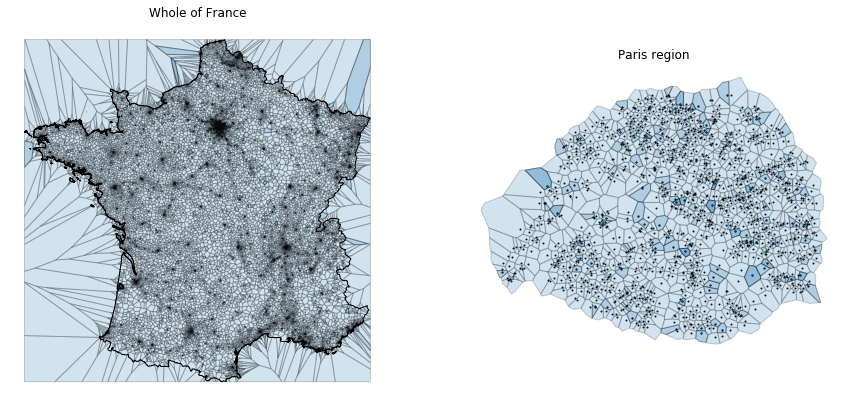

In [35]:
from descartes import PolygonPatch

vor = voronoi_polygons(_vor, fradm.bounds)
vor_sorted = [x[1] for x in sorted(vor.items(), key=lambda key_value: key_value[0])]
sir_geo['voronoi'] = vor_sorted

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))

# Whole of France
sir_geo.set_geometry('voronoi').plot(ax=ax1, alpha=.2, edgecolor='black')
ax1.add_patch(PolygonPatch(fradm, edgecolor='black', facecolor="None"))
ax1.axis('off')
ax1.set_title("Whole of France")

# Zoom-in on the paris region
sir_geo_paris = sir_geo.loc[sir_geo['depcom'].str[:2]=='75']
sir_geo_paris.plot(ax=ax2, marker='o', color='black', markersize=1)
sir_geo_paris.set_geometry('voronoi').plot(ax=ax2, alpha=.2, edgecolor='black')
ax2.axis('off')
ax2.set_title("Paris region")

for ax in [ax1, ax2]:
    ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
plt.show()

## Computation of demand-side variables

Once we have constructed proper polygons for the primary markets, the computation of demand-side information for all stores is straightforward: we simply need to intersect the primary (or higher-order) markets with the gridded data containing demand-related variables, and compute weighted averages. The only practical difficulty is to handle the volume of data, as we have about 30k markets, which we need to intersect with a grid containing roughly 140k polygons. A brute-force solution would involve computing in the order of 10e8 intersections. Thankfully, computation time can be drastically reduced by using some form of spatial indexing for one of the two datasets (indexing the bigger dataset will typically result in the best performance — i.e. the gridded data in our case). Here I do this using [R-trees](https://en.wikipedia.org/wiki/R-tree), which are provided out-of-the-box by the `shapely` package.


In [26]:
from shapely.strtree import STRtree

class Rectangle(Polygon):
    """Polygon subclass that can hold arbitrary data."""
    
    def __init__(self, shell=None, holes=None, data=None):
        super().__init__(shell, holes)
        self.data = data
        
# R-tree construction
rect_tree = STRtree([Rectangle(r.geometry, data=r) for r in rect.itertuples()])

After building the R-tree, it is pretty fast to compute the intersection between the Voronoi regions and the gridded data. Let's plot the intersection for a random store to see what it looks like.

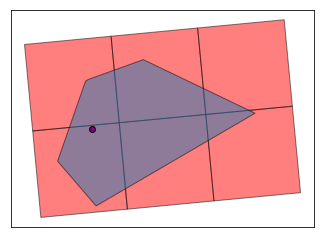

In [28]:
def plot_intersection(store_row, grid_rtree):
    """Plot the intersection between the gridded data and a store's Voronoi region."""
    
    inter = list()
    reg = store_row.voronoi.iloc[0]
    for c in grid_rtree.query(reg):
        if c.intersects(reg):
            inter.append(c)
    mtl = gpd.GeoSeries(MultiPolygon(inter))
    fig, ax = plt.subplots()
    mtl.plot(ax=ax, color='red', alpha=.5, edgecolor='black')
    store_row.set_geometry('voronoi').plot(ax=ax, alpha=.5, edgecolor='black')
    store_row.plot(ax=ax, marker='o', color='purple', edgecolor='black')
    ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
    plt.show()
    
plot_intersection(sir_geo.sample(1), rect_tree)

Now that we checked that everything looks good, we can compute demand-related information for a store based on the intersection with the gridded data. I simply compute the sum of the characteristics in each cell of the grid for those cells that intersect with a store's Voronoi region, weighting by the share of the cell's area located inside the Voronoi region. Here I compute the size of the market (number of individuals and households), and the total income of individuals in the market (the gridded data's [documentation](https://insee.fr/fr/statistiques/fichier/4176281/documentation_DonneesCarroyees.pdf) explains the information available in more details).

In [29]:
from tqdm.notebook import tqdm
tqdm.pandas()

def compute_demand_row(store_row, grid_rtree, cols):
    """Compute demand-related attributes for a store based on the 
    intersection between the Voronoi region and the gridded data.
    """
    
    res = np.zeros(len(cols))
    reg = store_row.voronoi
    cdt = grid_rtree.query(reg)
    if len(cdt) > 0:
        for s in cdt:
            prop = s.intersection(reg).area / s.area
            res += prop * np.array([getattr(s.data, v) for v in cols])
    return pd.Series({k:v for k,v in zip(cols, res)})

cols = ['Ind', 'Ind_snv']
sir_geo[cols] = sir_geo.progress_apply(lambda x: compute_demand_row(x, rect_tree, cols), axis=1)
sir_geo['nv'] = sir_geo['Ind_snv'] / sir_geo['Ind']

/Users/simongeorges/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Let's see what this looks like for the Paris region! Below I plot the size of each bakery's market in Paris and the average income (by consumption unit) of households in the market.

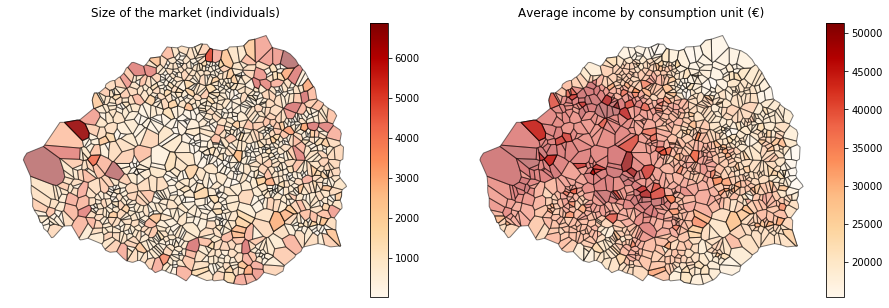

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

sir_geo_paris = sir_geo[sir_geo['depcom'].str[:2]=='75']

fig, axes = plt.subplots(1, 2, figsize=(15,15))
cols = {'Ind': 'Size of the market (individuals)', 'nv': 'Average income by consumption unit (€)'}
for a, (v, t) in zip(axes, cols.items()):
    div = make_axes_locatable(a)
    cax = div.append_axes("right", size="5%", pad=0.1)
    sir_geo_paris.set_geometry('voronoi').plot(v, edgecolor='black', alpha=.5, cmap='OrRd', legend=True,
                                           ax=a, cax=cax)
    a.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
    a.set_title(t)
    a.axis('off')

plt.show()

## Construction of supply-side variables

Many indicators for the competitive environment of stores can be computed in a much more straightforward manner than demand-side variables. For example, an interesting indicator might be the distance to the nearest competitor; another one could be the number of competitors within a given distance. These indicators can be easily and quickly computed if we use a proper spatial indexing structure. R-trees can also work here, but I wanted to try a different kind of data structure provided by `scipy` (with a fast implementation in C), called [k-d trees](https://en.wikipedia.org/wiki/K-d_tree). K-d trees and R-trees differ in the way they organize the space to enable fast queries. k-d trees recursively build separating hyperplanes, whereas R-trees build bounding rectangles that can overlap. A good comparison of both structures is available [here](https://stackoverflow.com/questions/4326332/what-is-the-difference-between-a-kd-tree-and-a-r-tree).

Below I compute the distance to the closest store and the number of stores within 1km and 5km of each store in the dataset. Computations are incredibly fast when I use the C implementation of k-d trees `cKDTree`.

In [31]:
from scipy.spatial import cKDTree

tree = cKDTree(sir_geo[['x', 'y']])
dist, idx = tree.query(sir_geo[['x', 'y']], 2) 
sir_geo['dist_closest'] = dist[:,1]
sir_geo['nb_1km'] = [len(x)-1 for x in tree.query_ball_point(sir_geo[['x', 'y']], 1000)]
sir_geo['nb_5km'] = [len(x)-1 for x in tree.query_ball_point(sir_geo[['x', 'y']], 5000)]

This is what the final dataset looks like: we added geographical information on market boundaries (`voronoi` column), demand-side information on the number of potential consumers and their income (`Ind` and `Ind_snv`), as well as some of the characteristics of the competition (`dist_closest`, `nb_1km` and `nb_5km`).

In [32]:
sir_geo.head()

,siret,x,y,depcom,geometry,voronoi,Ind,Ind_snv,nv,dist_closest,nb_1km,nb_5km
0,37963570900023,1042171.90,6300988.70,06088,POINT (1042171.900 6300988.700),"POLYGON ((1040320.417214978 6300928.997222394,...",2683.938485,6.095214e+07,22709.960239,29.748714,17,211
1,43128025400027,649378.40,6863880.10,75108,POINT (649378.400 6863880.100),"POLYGON ((649419.5349578944 6863739.24638323, ...",578.513497,2.395434e+07,41406.715286,0.000000,26,1103
2,39346965500046,931818.00,6895594.34,57463,POINT (931818.000 6895594.340),"POLYGON ((931864.3867347942 6895497.393439243,...",12.675323,3.247738e+05,25622.525951,12.096429,30,107
3,44001206000057,937050.00,6637350.00,39331,POINT (937050.000 6637350.000),"POLYGON ((935622.3466448887 6633385.327943237,...",297.689314,7.115522e+06,23902.510473,925.399391,1,4
4,40802811600015,623414.63,6390709.48,46102,POINT (623414.630 6390709.480),"POLYGON ((623382.2018712459 6390559.277231222,...",883.117236,1.958775e+07,22180.234174,46.360722,12,16
